## Project Final Report

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
set.seed(1234)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction

A research group in Computer Science at UBC, led by Frank Wood, collected data about how people play video games. They set up a MineCraft server, where the data collected consisted of two datasets: players.csv and sessions.csv. Our report will look at how player characteristics predict their number of played hours on the server. 

Our group was interested in the “kinds” of players that are most likely to contribute a large amount of data, such that they can be targeted in recruiting efforts. To investigate this, we chose the specific research question: **Can gender, experience, and age predict the total number of minutes of playtime from the dataset?** On a broader scale, these insights can help video game companies develop strategies that enhance user experience and engagement across diverse populations.

To answer the question, we must use both datasets provided (players.csv and sessions.csv). This data was collected by the UBC research group by recording play sessions, to collect information on player skill level, past play sessions, and player demographics. The players dataset contains data pertaining to our explanatory variables (gender, experience, age) whilst the sessions dataset contains data pertaining to the response variable (total playtime minutes).

### Datasets

**players.csv**
This dataset contains 196 observations and 7 variables: 
* Experience (character): Player’s level of experience with Minecraft.
* hashedEmail (character): Hashed version of the player’s email, likely for anonymity.
* name (character): Player's name.
* gender(character): Self-reported gender of.
* played_hours (double): Total number of hours a player has spent playing the player.
* age (double): Player's age
* subscribe (logical): Whether or not the player is subscribed to the game-related newsletter

**sessions.csv**
This dataset contains 1535 observations and 5 variables:
* hashedEmail (character): Hashed version of the player’s email, likely for anonymity.
* start_time (character): start date and time of play session.
* end_time (character): end date and time of play session.
* original_start_time (double): start time of a play seesion, in UNIX time.
* original_end_time (double): send of play session, in UNIX time.


**potential issues**
Upon examining the data, there are certain issues which may interfere with our data analysis if left unaddressed: 
* In players.csv, the age column has 2 missing values.
* In sessions.csv, start_time and end_time are in a character format, which should be converted to a proper datetime format and split in order to isolate the total hours played (the difference between end_time and start_time)
* There are outliers (i.e. individuals with extreme playtimes) which can skew the analysis.


## Methods and Results

First, we load in both datasets into our R environment. 

In [2]:
url_players<-"https://drive.google.com/uc?export=download&id=1M8-duCFfUh3MYjEn0j2WWRXzVMzTG97x"
players <- read_csv(url_players)

url_sessions <-"https://drive.google.com/uc?export=download&id=1DNxV79eDG7KkIWn6hIwgWeAeUN074SCS"
sessions <-read_csv(url_sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We then mutated and wrangled the data by converting the columns to their proper data types in preparation for visualization. In the sessions.csv dataset, we calculated the difference between the start and end time for a particular session to find the number of minutes played. For simplification, we also decided to merge both tidied datasets into one, using “hashedEmail” as the key.

In [12]:
players_tidy<- players|>
               mutate(gender=as_factor(gender))|>
               mutate(experience= as_factor(experience))|>
               filter(!is.na(played_hours))|>
               filter(!is.na(Age))
               

tidy_sessions <- sessions |>
    separate(col = start_time, into = c("start_date", "start_time"), sep = " ")|>
    separate(col = end_time, into = c("end_date", "end_time"), sep = " ")|>
    mutate(start_time = hm(start_time))|>
    mutate(end_time = hm(end_time))|>
    mutate(played_minutes = end_time-start_time)|>
    mutate(played_minutes = abs(as.numeric(played_minutes)/60))


data_combined<- inner_join(players_tidy, tidy_sessions, by = "hashedEmail")

data_selected<-data_combined|> select(Age, experience, played_minutes, gender)

data_summarized <- data_combined |> 
  summarise(
    n = n(),
    min_age = min(Age, na.rm = TRUE),
    max_age = max(Age, na.rm = TRUE),
    mean_age = mean(Age, na.rm = TRUE),
    median_age = median(Age, na.rm = TRUE),
    min_minutes = min(played_minutes, na.rm = TRUE),
    max_minutes = max(played_minutes, na.rm = TRUE),
    mean_minutes = mean(played_minutes, na.rm = TRUE),
    median_minutes = median(played_minutes, na.rm = TRUE))
data_summarized

data_split <- initial_split(data_selected, prop = 0.70, strata = played_minutes)
data_training <- training(data_split)
data_testing <- testing(data_split)

n,min_age,max_age,mean_age,median_age,min_minutes,max_minutes,mean_minutes,median_minutes
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1533,8,50,19.3516,18,3,1435,123.8021,31


Now, we summarize our quantitative explanatory variables to understand their basic properties. This provides early insight on the types of individuals that contribute large amounts of data to the server, helping target the research question.

We then proceeded with a few exploratory visualizations of our training dataset to better understand our predictor variables. 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


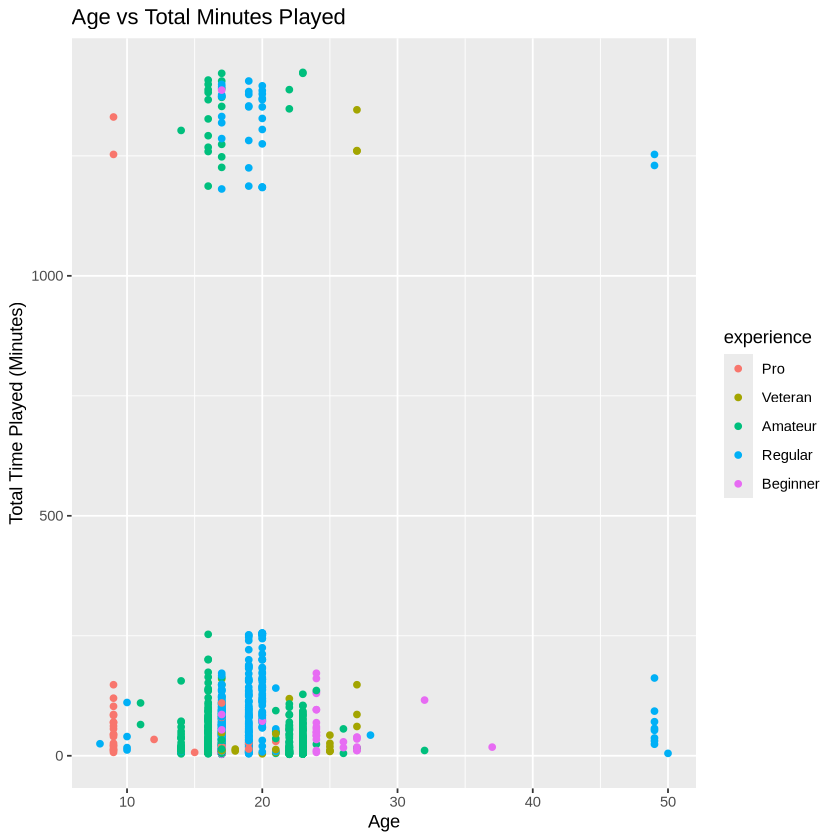

In [17]:
players_plot1<-data_training|>
               ggplot(aes(x=Age, y=played_minutes,color=experience))+
               geom_point()+
               labs(x="Age", y="Total Time Played (Minutes)", fill="Experience", title="Age vs Total Minutes Played")
players_plot1

*Figure 1. Visualization of Age vs Total minutes played categorized by Experience Level*

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


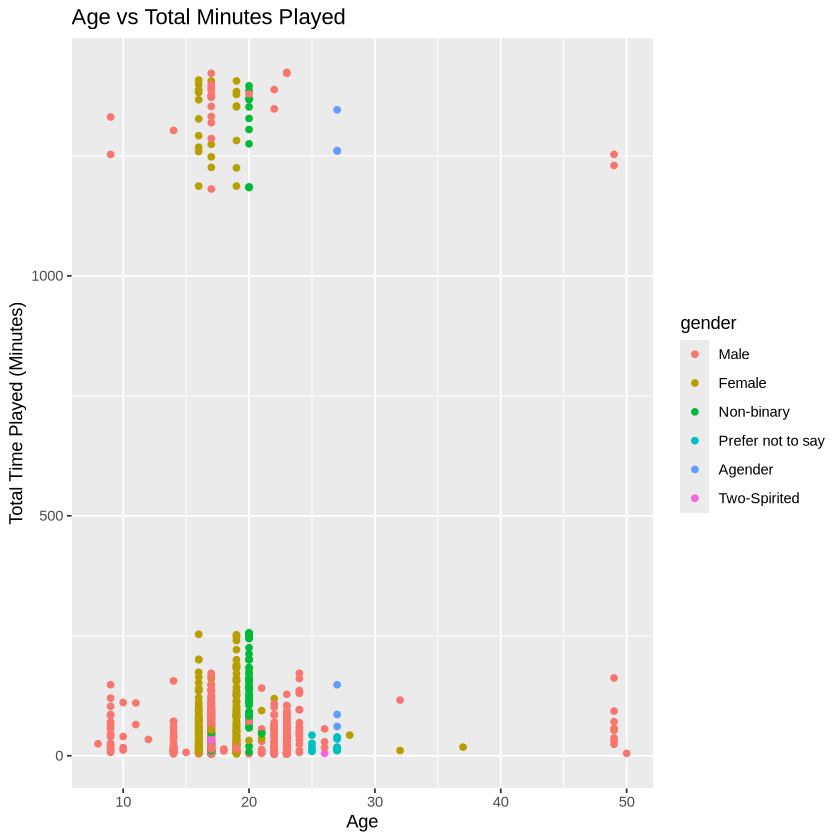

In [18]:
players_plot2<-data_training|>
               ggplot(aes(x=Age, y=played_minutes,color=gender))+
               geom_point()+
               labs(x="Age", y="Total Time Played (Minutes)", fill="Gender", title="Age vs Total Minutes Played")
players_plot2

*Figure 2. Visualization of Age vs Total minutes played categorized by Gender*

From these visualizations, it is evident that there are outliers in the original dataset – indicated by the data points with exceptionally high play times. In the context of this data, there are several explanations for these outliers. Some sessions may have never been properly closed (ex. Leaving the game open overnight) which can lead to high play times. Related to this, participants who are aware of the study may have played more/left a play session open for longer to generate data intentionally.

To mitigate the effect of outliers on our model’s predicting ability, we omitted play times over 1000 minutes in our final dataset. 

In [19]:
tidyer_sessions <- sessions |>
    separate(col = start_time, into = c("start_date", "start_time"), sep = " ")|>
    separate(col = end_time, into = c("end_date", "end_time"), sep = " ")|>
    mutate(start_time = hm(start_time))|>
    mutate(end_time = hm(end_time))|>
    mutate(played_minutes = end_time-start_time)|>
    mutate(played_minutes = abs(as.numeric(played_minutes)/60))|>
    filter(played_minutes <= 1000)


data_combined_cleaner<- inner_join(players_tidy, tidyer_sessions, by = "hashedEmail")

data_selected_cleaner<-data_combined_cleaner|> select(Age, experience, played_minutes, gender)

data_summarized_cleaner <- data_combined_cleaner |> 
  summarise(
    n = n(),
    min_age = min(Age, na.rm = TRUE),
    max_age = max(Age, na.rm = TRUE),
    mean_age = mean(Age, na.rm = TRUE),
    median_age = median(Age, na.rm = TRUE),
    min_minutes = min(played_minutes, na.rm = TRUE),
    max_minutes = max(played_minutes, na.rm = TRUE),
    mean_minutes = mean(played_minutes, na.rm = TRUE),
    median_minutes = median(played_minutes, na.rm = TRUE))
data_summarized_cleaner

data_split_cleaner <- initial_split(data_selected_cleaner, prop = 0.70, strata = played_minutes)
data_training_cleaner <- training(data_split_cleaner)
data_testing_cleaner <- testing(data_split_cleaner)

n,min_age,max_age,mean_age,median_age,min_minutes,max_minutes,mean_minutes,median_minutes
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1439,8,50,19.39333,18,3,256,46.90896,26


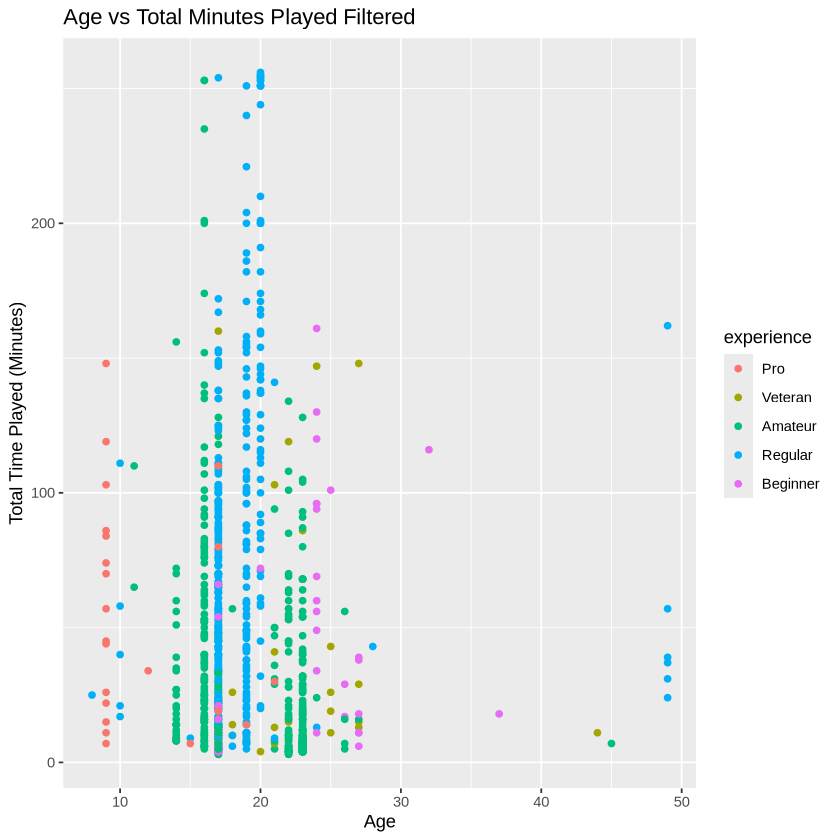

In [21]:
players_plot1_cleaner<-data_training_cleaner|>
               ggplot(aes(x=Age, y=played_minutes,color=experience))+
               geom_point()+
               labs(x="Age", y="Total Time Played (Minutes)", fill="Experience", title="Age vs Total Minutes Played Filtered")
players_plot1_cleaner

*Figure 3. Visualization of Age vs Total minutes played categorized by Experience Level while filtering out values above 10000*

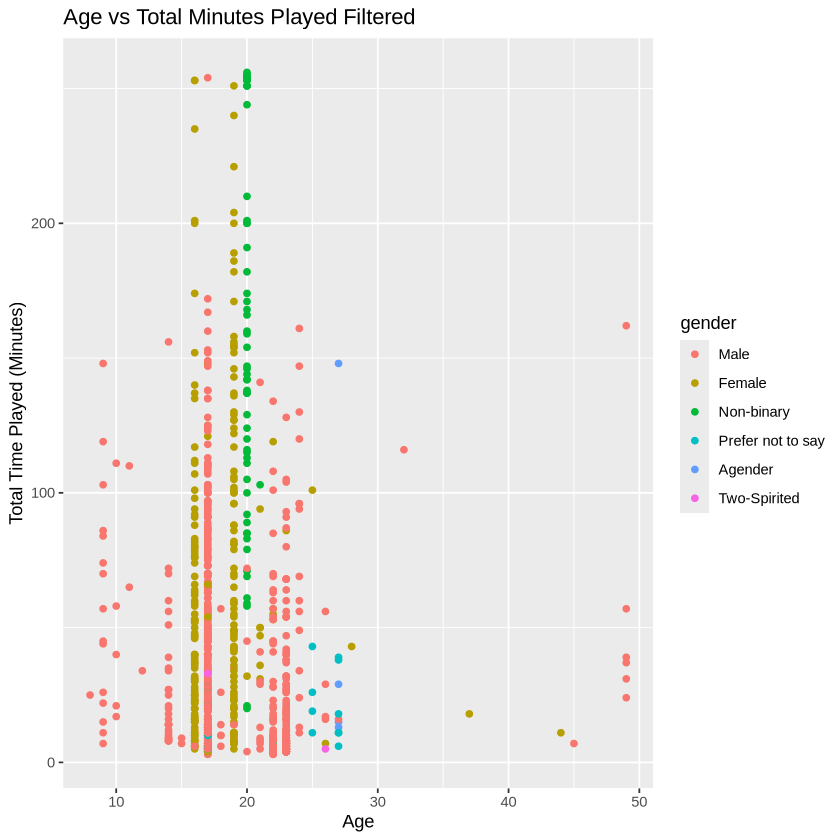

In [22]:
players_plot2_cleaner<-data_training_cleaner|>
               ggplot(aes(x=Age, y=played_minutes,color=gender))+
               geom_point()+
               labs(x="Age", y="Total Time Played (Minutes)", fill="Gender", title="Age vs Total Minutes Played Filtered")
players_plot2_cleaner

*Figure 4. Visualization of Age vs Total minutes played categorized by Gender while filtering out values above 10000*

From the visualizations, we decided on choosing k-nn regression as our model.
We chose k-nn regression because the relationship between the response variable and the predictor shows a nonlinear pattern. The assumption that was made for the KNN regression is that scaling is needed as the points should be in comparable scales in order to compare and calculate the distance between them. A limitation of this model is its slow performance – it must compute the distance of all the points inside the training set which can take time. In addition, the KNN method is also sensitive to the choice of k (number of neighbours). A value too small can lead to an overly sensitive model (overfitting) whilst a value too large can cause the model to ignore important local patterns (underfitting). 


As mentioned above, we are going to process the data by splitting it into training and testing sets.


There will be one initial split which will divide the data set 70% into the training set and 30% into the testing set. This allows us to train our model on the majority of the data, while reserving a portion for testing to evaluate the model’s performance. Then in the training set, we will perform a 5-fold-cross-validation to choose the correct number of neighbors (k). The split will happen before the modelling and the cross-validation is done on the training data.  The cross-validation happens to ensure that there will be an optimal value of K before testing it, leading to a more stable performance of the k-NN when estimating. 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,50.14255


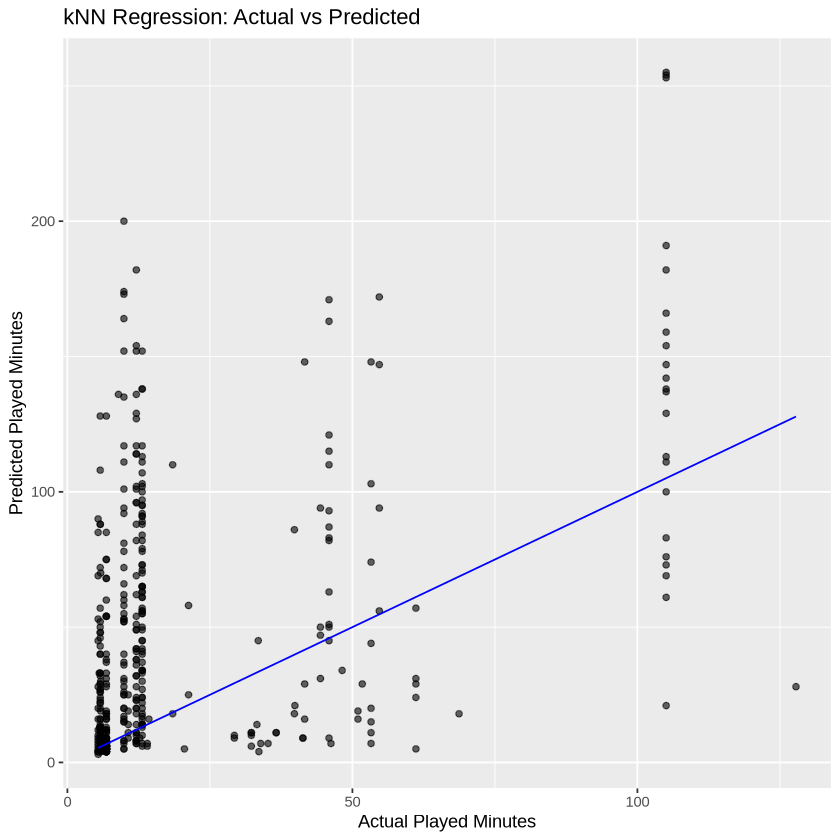

In [6]:
knn_recipe <- recipe(played_minutes ~ Age + experience + gender, data = data_training) |>
  step_dummy(all_nominal_predictors()) |> 
  step_zv(all_predictors())|>
  step_normalize(all_predictors())          

knn_model <- nearest_neighbor(mode = "regression",
  neighbors = tune() ) |>
  set_engine("kknn")


knn_workflow <- workflow() |>
  add_model(knn_model) |>
  add_recipe(knn_recipe)

folds <- vfold_cv(data_training, v=5, strata=played_minutes)

knn_grid <- grid_regular(neighbors(range = c(1,25)), levels =10)

knn_results <- tune_grid(
  knn_workflow,
  resamples = folds,
  grid = knn_grid,
  metrics = metric_set(rmse))

best_knn <- knn_results |>
  select_best(metric = "rmse")
final_knn_workflow <- finalize_workflow(knn_workflow, best_knn)

final_knn_fit <- final_knn_workflow |>
  fit(data = data_training)

final_preds <- predict(final_knn_fit, data_testing) |>
  bind_cols(data_testing)

rmse(final_preds, truth = played_minutes, estimate = .pred)

knn_plot<-ggplot(final_preds, aes(x = .pred , y = played_minutes)) +
  geom_point(alpha = 0.6) +
geom_line(data= final_preds, mapping=aes( y=.pred), color = "blue")+
  labs(x = "Actual Played Minutes", y = "Predicted Played Minutes",
       title = "kNN Regression: Actual vs Predicted")
knn_plot

*Figure 5. kNN Regression: Actual vs Predicted Played Minutes.*

## Discussion
The root mean squared error (RMSE) is 50.14, which means that the average that was done in the model prediction is off by 50 minutes from the actual played_minute values. This could also indicate that the predictors that were used are not strong enough to see the total playtime in minutes. The scatter plot of predicted vs actual played minutes shows a weak relationship, as many points are clustered near the origin with a wide spread. The fitted line indicates a positive relationship but this is poorly supported due to the skewed nature of the distribution.

This is what we expected to find – from our exploratory visualizations, we knew that play time was highly variable after seeing the number of outliers. We also expected this as even in our filtered data, the data was fairly imbalanced. There were a lot of players with low play time and only some with high play time. Therefore, we foresaw the RMSE value to be high because the predictors are not tightly clustered.

This finding is significant for the developers to understand the kinds of players that should be targeted in order to improve recruitment efforts. From this report, we can gather that demographic data alone may not be sufficient for predicting playtime engagement. More behavioural or technical data may be needed. 

The results of this report sparks further questions on how predictive capabilities in the context of this research question can be improved. Can we improve prediction accuracy by including additional variables (ex. Session duration)? Instead of K-NN modelling, what would be the effect of clustering players into distinct groups based on their demographics (ex. Casual vs. hardcore players)? Can adjusting game difficulty/content based on demographic data lead to longer play sessions? 

## References

Timbers , T., Campbell, T., & Lee , M. (n.d.). Data Science: A First Introduction. In 
        datasciencebook.ca. https://datasciencebook.ca/
